In [106]:
import torch
import hypothesis as h
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import glob

import hypothesis.plot

from hypothesis.plot import make_square
from matplotlib import cm

h.plot.activate()

In [107]:
from ratio_estimation import load_estimator
from ratio_estimation import compute_log_posterior
from setting import Simulator
from setting import Prior
from ratio_estimation import extent

In [ ]:
confidence_levels = np.linspace(0.05, 0.95, 19)

In [116]:
groundtruth = 1.0
simulator = Simulator()
x_o = simulator(torch.tensor(groundtruth))

print(x_o)

x_o = torch.tensor([[-0.3314, -0.0142, -0.8662, -0.3386,  0.7510, -0.2429, -0.6145, -0.5665,
         -0.4198, -0.7023, -0.9763, -0.8497, -0.5337, -0.1159, -0.0540, -0.0519,
         -0.4536, -0.7999, -0.4604, -0.9251]])  # Original observable

tensor([[-0.3314, -0.0142, -0.8662, -0.3386,  0.7510, -0.2429, -0.6145, -0.5665,
         -0.4198, -0.7023, -0.9763, -0.8497, -0.5337, -0.1159, -0.0540, -0.0519,
         -0.4536, -0.7999, -0.4604, -0.9251]])


In [290]:
!ls output/estimator/131072/128/0.001/*/weights.th

0  3		  bias.npy	     coverage.npy	mi-2.npy
1  4		  bias_square.npy    marginal_rhat.npy	variance.npy
2  balancing.npy  contour-sizes.npy  mi-1.npy


In [305]:
base = "output/estimator/1024/128/0.001"
elements = !ls $base | grep .0
lambdas = [int(float(el)) for el in elements]
lambdas.sort()

cmap = cm.coolwarm
norm = matplotlib.colors.LogNorm(vmin=lambdas[0], vmax=lambdas[-1])
colors = [
    cmap(norm(parameter))
    for parameter in lambdas
]

yellow = cm.get_cmap('viridis', 100).colors[-1]

In [ ]:
def load_balancing(parameter):
    files = glob.glob(f"output/estimator/1024/128/0.001/{float(parameter)}/*/balancing.npy")
    return np.mean([np.load(f) for f in files])

In [141]:
def load_coverages(parameter, subtract_cls=False):
    files = glob.glob(f"output/estimator/1024/128/0.001/{float(parameter)}/*/coverage.npy")
    if not subtract_cls:
        return np.vstack([
            np.flip(np.load(f).reshape(1, -1))
            for f in files
        ])
    else:
        return np.vstack([
            np.flip(np.load(f).reshape(1, -1)) - confidence_levels
            for f in files
        ])

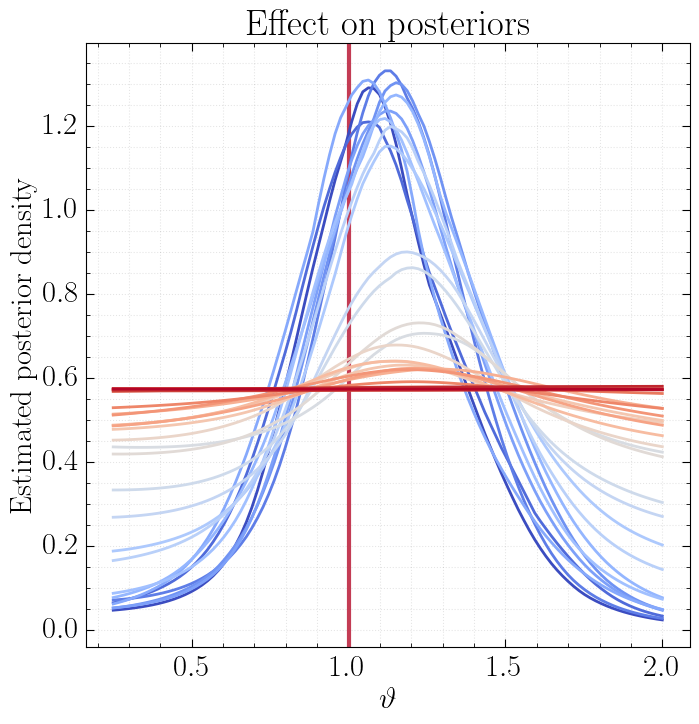

In [192]:
@torch.no_grad()
def effect_on_posteriors(ax):
    ax.set_xlabel(r"$\vartheta$")
    ax.set_ylabel("Estimated posterior density")
    ax.set_title("Effect on posteriors")
    ax.axvline(groundtruth, color="C3", linewidth=3)
    
    for i, parameter in enumerate(lambdas):
        estimator = load_estimator(f"{base}/{float(parameter)}/*/weights-final.th")
        log_pdf, inputs = compute_log_posterior(estimator, x_o)
        pdf = log_pdf.exp().numpy()
        inputs = inputs.numpy()
        ax.plot(inputs, pdf, c=colors[i])
        
    make_square(ax)

f = plt.figure()
effect_on_posteriors(plt.gca())
plt.show()

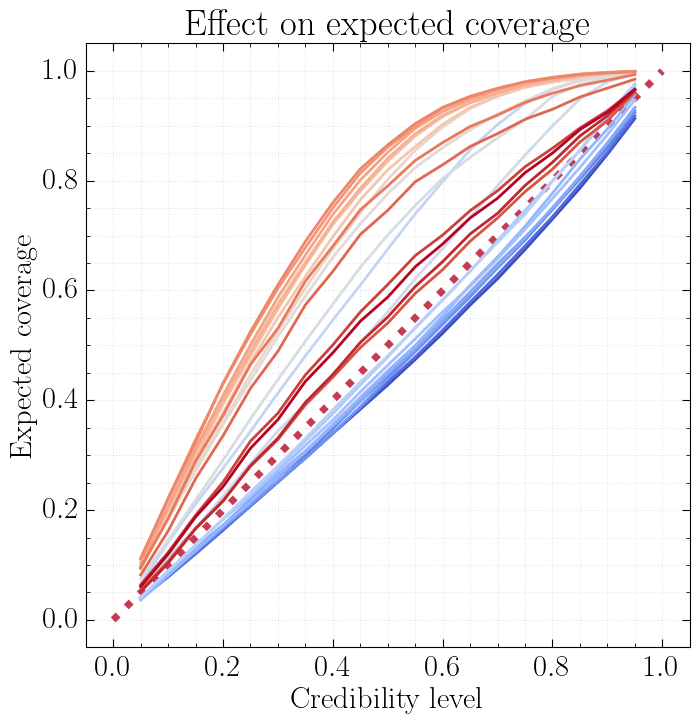

In [193]:
def effect_on_expected_coverage(ax):
    ax.set_ylabel('Expected coverage')
    ax.set_xlabel('Credibility level')
    ax.set_title('Effect on expected coverage')
    ax.plot([0, 1], [0, 1], linestyle=':', c="C3", linewidth=5)
    
    for i, parameter in enumerate(lambdas):
        coverages = load_coverages(parameter)
        ax.plot(confidence_levels, np.median(coverages, axis=0), c=colors[i])
        
    make_square(ax)
    
f = plt.figure()
effect_on_expected_coverage(plt.gca())
plt.show()

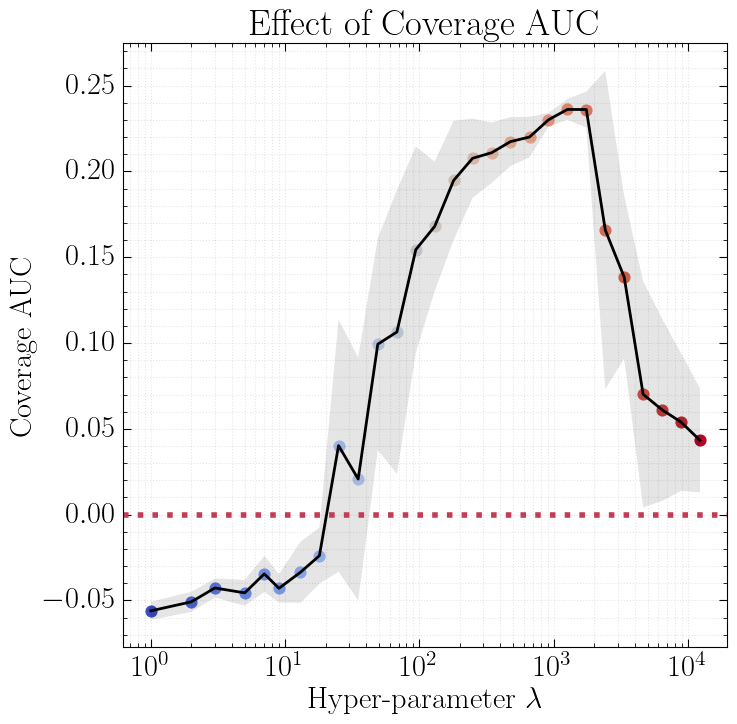

In [194]:
def effect_on_cauc(ax):
    ax.set_xlabel(r"Hyper-parameter $\lambda$")
    ax.set_ylabel("Coverage AUC")
    ax.set_title("Effect of Coverage AUC")
    ax.set_xscale('log')
    ax.axhline(0.0, color="C3", linewidth=4, linestyle=':')
    
    means = []
    stds = []
    
    # Compute the values
    for i, parameter in enumerate(lambdas):
        summed = np.sum(load_coverages(parameter, True), axis=1) / len(confidence_levels)
        means.append(np.mean(summed))
        stds.append(np.std(summed))
    
    # Scatterplot
    for i, parameter in enumerate(lambdas):
        cauc = means[i]
        ax.scatter([parameter], [cauc], s=60, c=[colors[i]])
    
    # Draw the line
    ax.plot(lambdas, means, c="C0", linewidth=2)
    
    m = np.array(means)
    s = np.array(stds)
    
    # Fill between
    ax.fill_between(lambdas, m - s, m + s, alpha=.1)
    
    make_square(ax)
    
f = plt.figure()
effect_on_cauc(plt.gca())
plt.show()

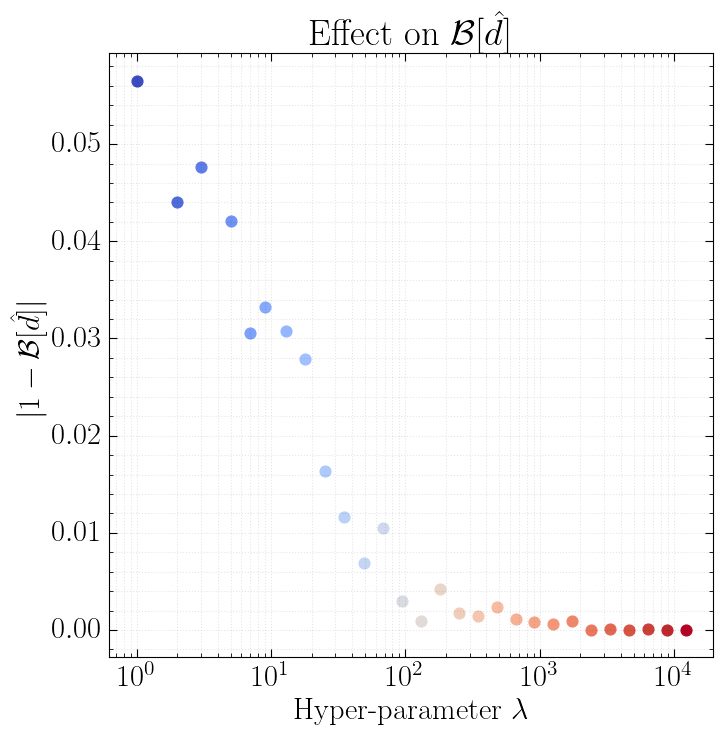

In [195]:
def effect_on_condition(ax):
    ax.set_xlabel(r"Hyper-parameter $\lambda$")
    ax.set_ylabel(r"$\vert1 - \mathcal{B}[\hat{d}]\vert$")
    ax.set_xscale('log')
    ax.set_title(r'Effect on $\mathcal{B}[\hat{d}]$')
    
    for i, parameter in enumerate(lambdas):
        b = np.abs(1 - load_balancing(parameter))
        ax.scatter([parameter], [b], s=60, c=[colors[i]])
        
    make_square(ax)
    
f = plt.figure()
effect_on_condition(plt.gca())
plt.show()

In [295]:
!ls output/estimator/131072/128/0.001/*/weights.th

ls: cannot access 'output/estimator/131072/128/0.001/*/weights.th': No such file or directory


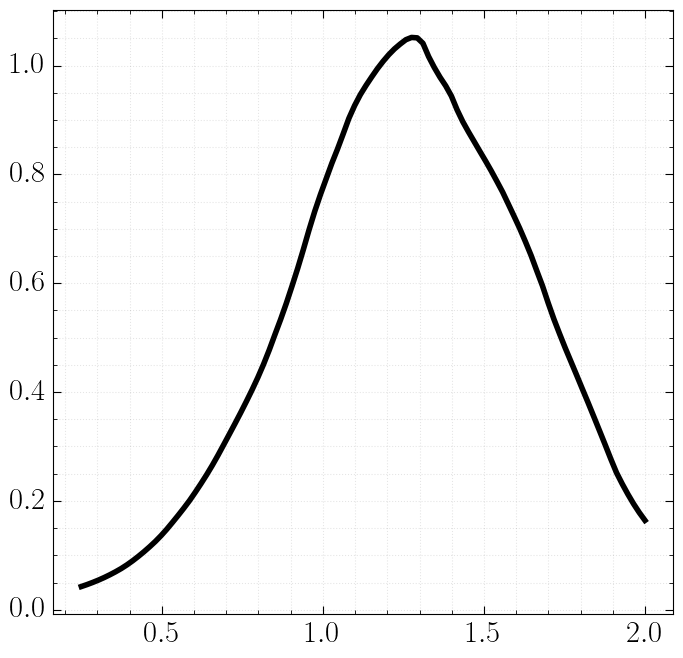

In [333]:
def add_nre(ax, color="C0"):
    estimator = load_estimator("output/estimator/131072/128/0.001/*/weights.th")
    log_pdf, inputs = compute_log_posterior(estimator, x_o)
    pdf = log_pdf.exp().numpy()
    inputs = inputs.numpy()
    return ax.plot(inputs, pdf, c=color, linewidth=4, label="NRE (131072 simulations)")
    
f = plt.figure()
add_nre(plt.gca())
plt.show()

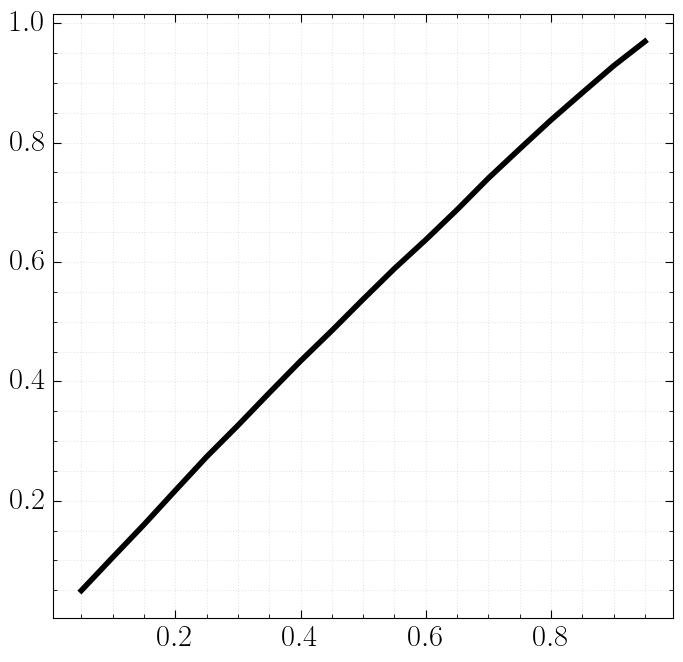

In [320]:
def add_nre_expected_coverage(ax, color="C0"):
    files = glob.glob(f"output/estimator/131072/128/0.001/*/coverage.npy")
    coverages = np.vstack([
        np.flip(np.load(f).reshape(1, -1))
        for f in files
    ])
    ax.plot(confidence_levels, np.median(coverages, axis=0), c=color, linewidth=4)
    
    
f = plt.figure()
add_nre_expected_coverage(plt.gca())
plt.show()

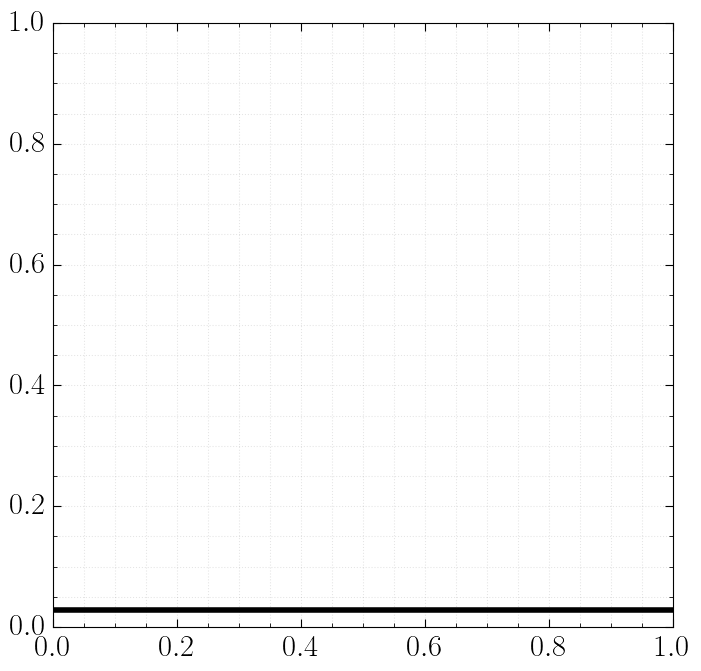

In [328]:
def add_nre_cauc(ax, color="C0"):
    files = glob.glob(f"output/estimator/131072/128/0.001/*/coverage.npy")
    coverages = np.vstack([
        np.flip(np.load(f).reshape(1, -1)) - confidence_levels
        for f in files
    ])
    cauc = np.median(np.sum(coverages, axis=1) / len(confidence_levels))
    ax.axhline(cauc, linewidth=4, color=color)
    
f = plt.figure()
add_nre_cauc(plt.gca())
plt.show()

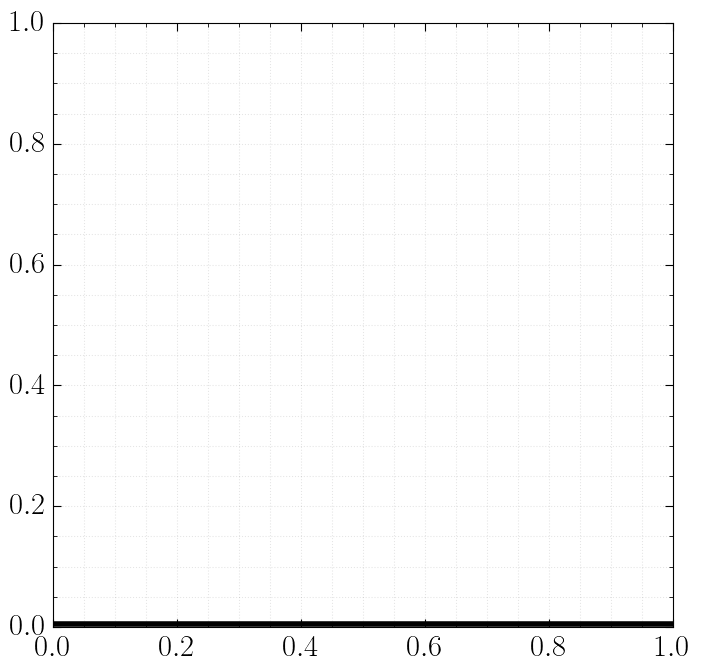

In [329]:
def add_nre_balancing(ax, color="C0"):
    files = glob.glob(f"output/estimator/131072/128/0.001/*/balancing.npy")
    b = np.median([np.load(f) for f in files])
    ax.axhline(np.abs(1-b), color=color, linewidth=4)
    
f = plt.figure()
add_nre_balancing(plt.gca())
plt.show()

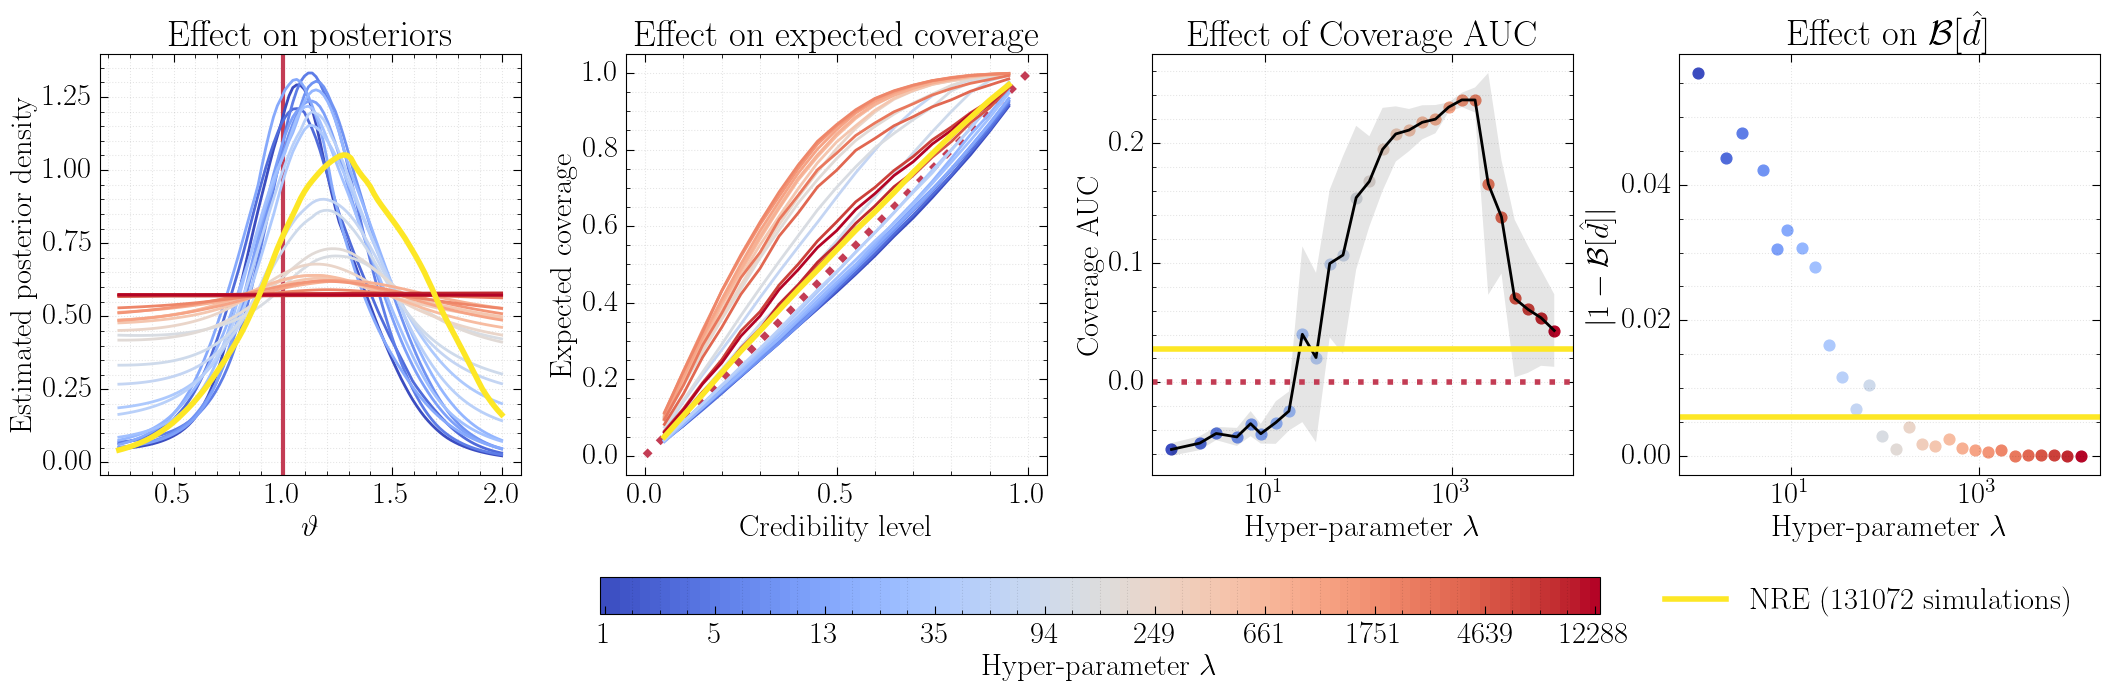

In [343]:
nre_color = yellow

figure, axes = plt.subplots(1, 4, figsize=(4 * 5, 5))

effect_on_posteriors(axes[0])
add_nre(axes[0], color=nre_color)
effect_on_expected_coverage(axes[1])
add_nre_expected_coverage(axes[1], color=nre_color)
effect_on_cauc(axes[2])
add_nre_cauc(axes[2], color=nre_color)
effect_on_condition(axes[3])
add_nre_balancing(axes[3], color=nre_color)

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.25, hspace=0)

cax = figure.add_axes([0.25, -0.2, 0.5, 0.075])
cax.set_xscale('linear')
fmt = matplotlib.ticker.ScalarFormatter(useMathText=True)
fmt.set_powerlimits((-2, 2))
ticks = np.linspace(0, 1, len(lambdas))[::3]
cb = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, values=np.linspace(0, 1, 100), orientation='horizontal')
cb.set_ticks(ticks)
cb.set_ticklabels(lambdas[::3])
cb.set_label(r'Hyper-parameter $\lambda$')

figure.legend(loc='lower right', bbox_to_anchor=(1, -0.26))


figure.savefig('no_batman.pdf', bbox_inches='tight')
figure.show()